# Case study: deflection of a membrane

We consider a more physically meaningful model:
\begin{equation}
-\Delta w = 4\exp{\left(
- \beta^2(x^2
+ (y-R_0)^2)\right)},
\end{equation}
to be solved over the unit disc with $w=0$ on the boundary. This model is related to the calculation of the deflection of a membrane. Here, $\beta$ is a dimensionless parameter, and $[0, R_0]$ is the location of the pressure peak.
Some more details about the background of the problem can be found at the end of this Notebook.

We now modify the code to solve this new problem.

## Implementation in FEniCS

### Import packages

We start by importing fenics and enforcing matplotlib. In addition, we import mshr for mesh generation.

In [1]:
from fenics import *
from mshr import *

%matplotlib inline

### Generate the mesh and define function space

A mesh over the unit disk can be created by the mshr tool in FEniCS.

In particular, we can the `Circle` class. It defines a domain by taking
the center and radius of the circle as arguments. We can then generate
the mesh for the domain using the `generate_mesh` function. The second argument 
to the `generate_mesh` function specifies the desired mesh resolution. The 
cell size will be (approximately) equal to the diameter of the domain 
divided by the resolution.

Calling FFC just-in-time (JIT) compiler, this may take some time.


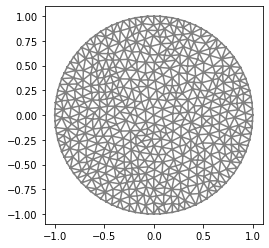

In [2]:
domain = Circle(Point(0, 0), 1)
mesh = generate_mesh(domain, 16)
plot(mesh)

V = FunctionSpace(mesh, 'P', 2)

Similarly, we can also generate a 3-D mesh using the following commands:
```
domain = Sphere(Point(0, 0), 1)
mesh = generate_mesh(domain, 16)
plot(mesh)
```

### Define the Variational Problem

In [3]:
w = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(w), grad(v))*dx

### Define the load

The right-hand side pressure function
is represented by an `Expression` object. There
are two physical parameters in the formula for $f$ that enter the
expression string and these parameters must have their values set
by keyword arguments:

In [4]:
beta = 8
R0 = 0.8
p = Expression('4*exp(-pow(beta, 2)*(pow(x[0], 2) + pow(x[1] - R0, 2)))',
               degree=1, beta=beta, R0=R0)
L = p * v * dx

The coordinates in `Expression` objects are always an array
`x` with components `x[0]`, `x[1]`, and `x[2]`, corresponding to
$x$, $y$, and $z$.
Otherwise we are free to introduce names of parameters as long as
these are given default values by keyword arguments. All the
parameters initialized by keyword arguments can at any time have their
values modified. For example, we may set
```
p.beta = 12
p.R0 = 0.3
```

We also need to define a function space and boundary conditions:

In [5]:
def u0_boundary(x, on_boundary):
    return on_boundary

u0 = Constant(0)
bc = DirichletBC(V, u0, u0_boundary)

### Solve the variational problem

The variational problem and the boundary conditions are the same as in
our first Poisson problem, but we may introduce `w` instead of `u` as
primary unknown and `p` instead of `f` as right-hand side function:

In [6]:
w = Function(V)
solve(a == L, w, bc)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


## Post-Processing
### Plot the solution

It is of interest to visualize the pressure $p$ along with the
deflection $w$ so that we may examine the membrane's response to the
pressure. We must then transform the formula (`Expression`) to a
finite element function (`Function`). The most natural approach is to
construct a finite element function whose degrees of freedom are
calculated from $p$. That is, we interpolate $p$ to the function space
$\mathcal{V}$:

In [7]:
p = interpolate(p, V)

Note that the assignment to `p` destroys the previous `Expression`
object `p`, so if it is of interest to still have access to this
object, another name must be used for the `Function` object returned
by `interpolate`. The two functions `w` and `p` may be plotted
using the built-in plot command:

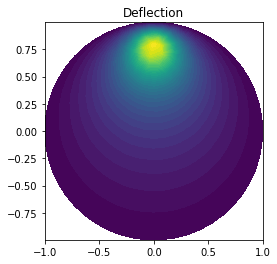

In [8]:
plot(w, title='Deflection')

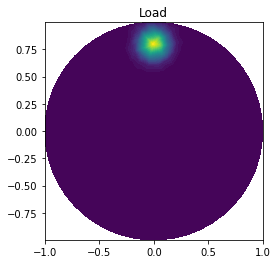

In [9]:
plot(p, title='Load')

In [10]:
vtkfile_w = File('membrane/deflection.pvd')
vtkfile_w << w
vtkfile_p = File('membrane/load.pvd')
vtkfile_p << p

### Make curve plots through the domain

Another way to compare the deflection and the load is to make a curve plot
along the line $x=0$. This is just a matter of defining a set of points
along the $y$-axis and evaluating the finite element functions `w` and `p`
at these points:

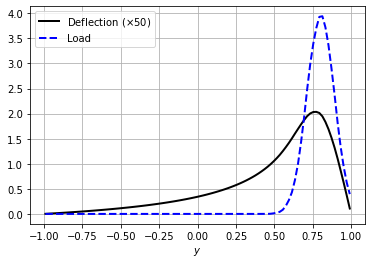

In [14]:
# Curve plot along x = 0 comparing p and w
import numpy as np
import matplotlib.pyplot as plt

tol = 0.01  # avoid hitting points outside the domain
y = np.linspace(-1 + tol, 1 - tol, 101)
points = [(0, y_) for y_ in y]  # 2D points
w_line = np.array([w(point) for point in points])
p_line = np.array([p(point) for point in points])

plt.plot(y, 50*w_line, 'k', linewidth=2)  # magnify w
plt.plot(y, p_line, 'b--', linewidth=2)
plt.grid(True)
plt.xlabel('$y$')
plt.legend(['Deflection ($\\times 50$)', 'Load'], loc='upper left')


In [16]:
plt.savefig('membrane/curves.pdf')
plt.savefig('membrane/curves.png')

<Figure size 432x288 with 0 Axes>

### Visualize using ParaView

We also export the solutions in VTK format for visualization in [ParaView](http://www.paraview.org/), 
which is a powerful tool for visualizing  scalar and vector fields, including those
computed by FEniCS.

We first export the solution in VTK format:

The following steps demonstrate how to create a plot of the solution
of our Poisson problem in ParaView.

 - Start the ParaView application.
 - Click **File--Open...** in the top menu and navigate to the directory containing the exported solution. This should be inside a subdirectory named `poisson_membrane` below the directory where the FEniCS Python program was started. Select the file named `deflection.pvd` and then click **OK**.
 - Click **Apply** in the Properties pane on the left. This will bring up a plot of the solution.
 - To make a 3D plot of the solution, we will make use of one of ParaView's many *filters*. Click **Filters--Alphabetical--Warp By Scalar** in the top menu and then **Apply** in the Properties pane on the left. This create an elevated surface with the height determined by the solution value.
 - To show the original plot below the elevated surface, click the little eye icon to the left of `deflection.pvd` in the Pipeline Browser pane on the left. Also click the little 2D button at the top of the plot window to change the visualization to 3D. This lets you interact with the plot by rotating (left mouse button) and zooming (Ctrl + left mouse button).
 - To show the finite element mesh, click on `deflection.pvd` in the Pipeline Browser, navigate to _Representation_ in the Properties pane, and select **Surface With Edges**. This should make the finite element mesh visible.
 - To change the aspect ratio of the plot, click on **WarpByScalar1** in
 the Pipeline Browser and navigate to _Scale Factor_ in the Properties
 pane. Change the value to 10 and click **Apply**. This will change the
 scale of the warped plot. We also unclick **Orientation Axis
 Visibility** at the bottom of the Properties pane to remove the little
 3D axes in the lower left corner of the plot window.
 - Finally, to export the visualization to a file, click **File--Save Screenshot...** and select a suitable file name such as `membrane.png`.

For more information, we refer to [The ParaView Guide](http://www.paraview.org/paraview-guide/), [ParaView tutorial](
http://www.paraview.org/Wiki/The_ParaView_Tutorial), and the instruction
video [Introduction to ParaView](https://vimeo.com/34037236).

## Notes on origin of model problem

The model problem is originated from computing the deflection $D(x,y)$ of 
a two-dimensional, circular membrane of radius $R$, subject to a load $p$ over the
membrane. The appropriate PDE model is

\begin{equation}
-T\Delta D = p\quad\hbox{in }\Omega = \{ (x,y)\,\vert\, x^2+y^2\leq R\}
\end{equation}

Here, $T$ is the tension in the membrane (constant), and $p$ is the external
pressure load.
The boundary of the membrane has no
deflection, implying $D=0$ as a boundary condition.
A localized load can be modeled as a Gaussian function:

\begin{equation}
p(x,y) = {A\over 2\pi\sigma}\exp{\left(
- {1\over2}\left( {x-x_0\over\sigma}\right)^2
- {1\over2}\left( {y-y_0\over\sigma}\right)^2
\right)}\, .
\end{equation}

The parameter $A$ is the amplitude of the pressure, $(x_0,y_0)$ the
localization of the maximum point of the load, and $\sigma$ the
``width'' of $p$. We will take the center $(x_0,y_0)$ of the pressure
to be $(0, R_0)$ for some $0 < R_0 < R$.

There are many physical parameters in this problem. We can benefit
from grouping them by means of scaling. Let us introduce dimensionless
coordinates $\bar x = x/R$, $\bar y = y/R$, and a dimensionless
deflection $w=D/D_c$, where $D_c$ is a characteristic size of the
deflection. Introducing $\bar R_0=R_0/R$, we obtain

$$ -\frac{\partial^2 w}{\partial\bar x^2}
-\frac{\partial^2 w}{\partial\bar y^2}= \alpha
\exp{\left(
- \beta^2(\bar x^2
+ (\bar y-\bar R_0)^2)\right)}\hbox{ for } \bar x^2 + \bar y^2 < 1,$$

where

$$ \alpha = \frac{R^2A}{2\pi T D_c\sigma},\quad\beta = \frac{R}{\sqrt{2}\sigma}.$$

With an appropriate scaling, $w$ and its derivatives are of size
unity, so the left-hand side of the scaled PDE is about unity in size,
while the right-hand side has $\alpha$ as its characteristic size.
This suggest choosing $\alpha$ to be unity, or around unity. We shall
in this particular case choose $\alpha=4$. (One can also find the
analytical solution in scaled coordinates and show that the maximum
deflection $D(0,0)$ is $D_c$ if we choose $\alpha=4$ to determine
$D_c$.) With $D_c=AR^2/(8\pi\sigma T)$ and dropping the bars we obtain
the scaled problem

\begin{equation}
-\Delta w = 4\exp{\left(
- \beta^2(x^2
+ (y-R_0)^2)\right)},
\end{equation}

to be solved over the unit disc with $w=0$ on the boundary. Now
there are only two parameters to vary: the dimensionless extent of the
pressure, $\beta$, and the localization of the pressure peak, $R_0\in
[0,1]$.  As $\beta\rightarrow 0$, the solution will approach the
special case $w=1-x^2-y^2$.

The above PDE is what we solved above. Given a computed scaled solution $w$, 
the physical deflection can be computed by
$$ D = \frac{AR^2}{8\pi\sigma T}w$$

**Acknowledgment**: This notebook was adapted from Chapter 1 of [The FEniCS Tutorial Volume I](https://fenicsproject.org/pub/tutorial/sphinx1/) by Hans Petter Langtangen and Anders Logg, released under CC Attribution 4.0 license.